# 해외주식 고객 분석 

### 분석 개요
**목적**
    - 해외주식 거래고객과 비거래고객 비교 분석을 통한 특징 분석
    - 머신러닝 모델을 활용하여 해외주식 거래확률 예측
**데이터** 
    - 당사 거래고객 중 18.4월 해외주식 거래 3만명 + 미거래 3만명 = 총 6만명 추출. 자산 10만원미만 고객 제외
**피처 설명**
    - 피처('17.10~18.3월) : 성별, 연령, 자산규모, 매매내역, 온라인매체이용 등 80여개 항목
    - 타겟('18.4월) : 해외주식 거래여부
---

## 1. 준비작업
분석용 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 그래프 한글 출력
import matplotlib
from matplotlib import font_manager, rc, style, rcParams

fontName=font_manager.FontProperties(fname="/usr/share/fonts/truetype/nanum/NanumGothic_Coding.ttf").get_name()
matplotlib.rcParams['axes.unicode_minus']=False
rc("font",family=fontName)

/home/bt01/.pyenv/versions/3.4.3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from scipy import stats                    # box-cox transformation, t-test
from scipy.stats import chi2_contingency   # 카이제곱 검정(분할표)

데이터 읽어오기(※ 데이터 추출 및 정리 작업은 별도 파일에서 실행)

In [295]:
t1 = pd.read_pickle('target_1.pkl')   #  해외주식 미거래(3만명)
t2 = pd.read_pickle('target_2.pkl')   #  해외주식 거래(3만명)

df = pd.concat([t1, t2])
df.reset_index(drop=True, inplace=True)

df.head()

,AGE,CUST_NEW_REG_DATE,SEX_SECT_CD,MAIN_GOODS_CD,MAIN_CHNL_CD,CUST_GRAD_CD,ACC_CNT,ACC_MANAGER,ACC_DIRECT,ACC_DW,...,ASSET_PCT_OVERSEA,STK_AMT_R,DEP_AMT_R,FUND_AMT_R,ELSDLS_AMT_R,TRUST_AMT_R,fund_turnover,stock_turnover,max_channel,target
0,35.0,20160420,02,05,2,A,1.0,1.0,0.0,1.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,NoUse,0
1,57.0,19911203,01,12,2,A,NaN,1.0,NaN,NaN,...,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,NoUse,0
2,48.0,20060510,01,01,1,A,1.0,1.0,0.0,0.0,...,0.0,0.887764,0.112236,0.0,0.0,0.0,0.0,0.684567,HTS,0
3,42.0,20011129,02,01,1,R,2.0,1.0,1.0,0.0,...,0.0,0.995942,0.004058,0.0,0.0,0.0,0.0,2.456475,HTS,0
4,52.0,20070315,02,10,2,A,1.0,1.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,NoUse,0


의미없는 피처 삭제 : 결측값 포함, 중복 추출 데이터 등  
과적합 위험이 있는 해외주식 직접 연관 피처는 뺀다(전월 해외자산, 보유여부 등)

In [296]:
del_varlist = \
    ['ACC_CNT','ACC_MANAGER','ACC_DIRECT', 'ACC_DW', 'ACC_MR','ACC_UN','GLST_TR_YN_BASE','GLST_TR_YN_TG',
     'GLST_HLD_YN_BASE','GLST_HLD_YN_TG',
     'FUND_HOLD_YN_BASE','FUND_HOLD_YN_TG','FP_HOLD_YN_BASE','FP_HOLD_YN_TG','GLFD_HOLD_YN_LAST','GLFD_HOLD_YN_BASE',
     'GLFD_HOLD_YN_TG','PEN_HOLD_YN_BASE','PEN_HOLD_YN_TG'] + \
    ['AGE_G','CUST_NEW_REG_DATE','goods','SEX_SECT_CD','MAIN_GOODS_CD','MAIN_CHNL_CD', 'ASSET_ST_JP_WT', 
     'FP_TRADE_MON', 'FP_HOLD_YN_LAST', 'ASSET_PCT_BOND', 'ASSET_ST_EU_WT'] + \
    ['GLST_HLD_YN_LAST', 'FSTK_AMT']   
    
df.drop(del_varlist, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

피처 데이터(X)와 타겟 데이터(y)로 분리

In [297]:
X = df.drop(['target'], axis=1)
y = df['target']

해외주식 미거래고객수(라벨 0) :  30000
해외주식 거래고객수(라벨 1) :  30000


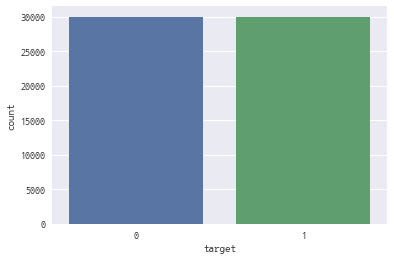

In [108]:
ax = sns.countplot(y, label='Count')  # 0 -> 해외주식 미거래, 1 -> 해외주식 거래
A, B = y.value_counts()
print('해외주식 미거래고객수(라벨 0) : ', A)
print('해외주식 거래고객수(라벨 1) : ', B)

간단한 요약 통계 : **피처별로 값 범위가 다양 -> 스케일 조정 필요**

In [298]:
print(X.shape)
X.describe()

(60000, 76)


,AGE,manager,direct,acc_dw,acc_mr,acc_un,tenure_year,TOT_AMT,STK_AMT,FO_AMT,...,ASSET_PCT_STOCK,ASSET_PCT_KOREA,ASSET_PCT_OVERSEA,STK_AMT_R,DEP_AMT_R,FUND_AMT_R,ELSDLS_AMT_R,TRUST_AMT_R,fund_turnover,stock_turnover
count,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,6.000000e+04,6.000000e+04,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,48.16935,0.687650,0.204417,0.554417,0.442450,0.122317,11.536650,1.540783e+08,6.862854e+07,8.508820e+05,...,0.812594,0.508221,0.344828,0.380269,0.175082,0.126301,0.013543,0.023097,0.038059,0.897181
std,14.86146,0.463456,0.403278,0.497034,0.496681,0.327654,8.909006,2.500771e+09,1.369311e+09,9.845561e+07,...,0.292561,0.408084,0.409669,0.403404,0.289580,0.267954,0.079963,0.108165,0.122097,2.062707
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05,0.000000e+00,0.000000e+00,...,-0.105200,-0.110100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.312863e+06,0.000000e+00,0.000000e+00,...,0.760000,0.000300,0.000000,0.000000,0.002671,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.00000,1.000000,0.000000,1.000000,0.000000,0.000000,10.000000,2.346291e+07,1.601105e+06,0.000000e+00,...,0.953200,0.565350,0.039850,0.203846,0.031237,0.000000,0.000000,0.000000,0.000000,0.112608
75%,58.00000,1.000000,0.000000,1.000000,1.000000,0.000000,18.000000,9.672377e+07,2.425885e+07,0.000000e+00,...,0.998100,0.884800,0.779900,0.820073,0.199061,0.082525,0.000000,0.000000,0.001778,0.631795
max,100.00000,1.000000,1.000000,1.000000,1.000000,1.000000,44.000000,4.561265e+11,1.840813e+11,2.278848e+10,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


---
## 2.기초분석
피처수가 너무 많음. 해외주식 거래여부에 유의한 영향을 미치는 피처를 선별하여 집중적으로 분석
  - **피처 선택은?** 랜덤포레스트의 변수중요도(Feature Importance) 활용
  - **분석 방법은?** Seaborn 라이브러리의 시각화 차트 구현
  - **텍스트 피처는?** 집계표와 카이스퀘어 통계량으로 분석

랜덤포레스트 돌리기 위해 텍스트 피처 더미처리(pd.get_dummies)

In [111]:
txt_varlist = ['CUST_GRAD_CD', 'gender', 'goods_2', 'channel', 'cust_grad','max_channel']  # 더미처리할 피처
txt_prelist = ['cust_grad', 'gender', 'goods', 'channel', 'cust_grad2','max_channel']      # 더미처리된 피처명의 prefix

X = pd.concat([X,
               pd.get_dummies(X.loc[:, txt_varlist], prefix=txt_prelist)],
              axis=1)
X.drop(txt_varlist, axis=1, inplace=True)                                                  # 더미처리한 피처는 날리자!

In [112]:
X.head()   # 더미 처리된 피처는 맨 뒤에!!! 

,AGE,manager,direct,acc_dw,acc_mr,acc_un,tenure_year,TOT_AMT,STK_AMT,FO_AMT,...,goods_펀드,channel_오프라인,channel_온라인,cust_grad2_Honor,cust_grad2_MASS,cust_grad2_VIP,max_channel_HTS,max_channel_MTS,max_channel_NoUse,max_channel_Web
0,35.0,1,0,1,0,0,2.0,641958.0,0.0,0.0,...,0,1,0,0,1,0,0,0,1,0
1,57.0,0,0,0,0,0,26.0,125700.0,0.0,0.0,...,0,1,0,0,1,0,0,0,1,0
2,48.0,1,0,0,1,0,12.0,16160726.0,14346910.0,0.0,...,0,0,1,0,1,0,1,0,0,0
3,42.0,1,1,0,1,0,16.0,291928434.0,290743700.0,0.0,...,0,0,1,0,0,1,1,0,0,0
4,52.0,1,0,0,1,0,11.0,808714.0,0.0,0.0,...,0,1,0,0,1,0,0,0,1,0


** 랜덤포레스트 변수 중요도 뽑기~!**

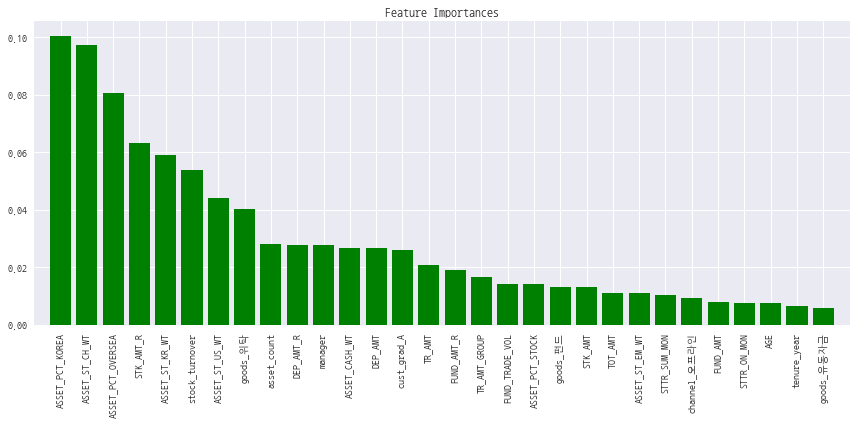

In [114]:
# 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 변수 중요도 
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
n = 30   # 피처 보유 줄 갯수
plt.figure(1, figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(n), 
        importances[indices][:n],
        color='g', align='center')
plt.xticks(range(n), 
           X_train.columns[indices][:n], rotation=90)
plt.xlim([-1, n])
plt.tight_layout()
plt.show()

In [115]:
X_train.columns[indices][:30]

Index(['ASSET_PCT_KOREA', 'ASSET_ST_CH_WT', 'ASSET_PCT_OVERSEA', 'STK_AMT_R',
       'ASSET_ST_KR_WT', 'stock_turnover', 'ASSET_ST_US_WT', 'goods_위탁',
       'asset_count', 'DEP_AMT_R', 'manager', 'ASSET_CASH_WT', 'DEP_AMT',
       'cust_grad_A', 'TR_AMT', 'FUND_AMT_R', 'TR_AMT_GROUP', 'FUND_TRADE_VOL',
       'ASSET_PCT_STOCK', 'goods_펀드', 'STK_AMT', 'TOT_AMT', 'ASSET_ST_EM_WT',
       'STTR_SUM_MON', 'channel_오프라인', 'FUND_AMT', 'STTR_ON_MON', 'AGE',
       'tenure_year', 'goods_유동자금'],
      dtype='object')

In [116]:
importances[indices][:30]

array([ 0.10045254,  0.09736819,  0.08072411,  0.06328802,  0.05897681,
        0.05387185,  0.04419324,  0.04009795,  0.02807427,  0.02791566,
        0.02779938,  0.02679083,  0.02657556,  0.02599101,  0.02085522,
        0.01898763,  0.0165399 ,  0.01416811,  0.01410448,  0.01320643,
        0.01299306,  0.01096565,  0.01088287,  0.01044508,  0.00917673,
        0.00800313,  0.00760777,  0.00741978,  0.00665587,  0.00598804])

**참고** : 설명력이 가장 높은 상위 30개 피처는 70여개 전체 피처의 설명력 중 89%를 점유

In [117]:
print("Top 30 Features - Cumulative Importances ratio : ", np.sum(importances[indices][:29]))

Top 30 Features - Cumulative Importances ratio :  0.890119193058


---
### 피처 중요도 상위 20개 : 시각화

상위 20개 피처 중에서 텍스트형 피처는 제외하고 수치형만 뽑자~!

In [119]:
del_var = ['goods_위탁', 'cust_grad_A', 'manager', 'cust_grad2_VIP', 'channel_온라인', 'channel_오프라인','goods_펀드']
top20_num = []

for v in X_train.columns[indices][:30].tolist():
    if v not in del_var:
        top20_num.append(v) 
    if len(top20_num) == 20:
        break

top20_num

['ASSET_PCT_KOREA',
 'ASSET_ST_CH_WT',
 'ASSET_PCT_OVERSEA',
 'STK_AMT_R',
 'ASSET_ST_KR_WT',
 'stock_turnover',
 'ASSET_ST_US_WT',
 'asset_count',
 'DEP_AMT_R',
 'ASSET_CASH_WT',
 'DEP_AMT',
 'TR_AMT',
 'FUND_AMT_R',
 'TR_AMT_GROUP',
 'FUND_TRADE_VOL',
 'ASSET_PCT_STOCK',
 'STK_AMT',
 'TOT_AMT',
 'ASSET_ST_EM_WT',
 'STTR_SUM_MON']

차트를 이쁘게 보기 위해, 피처를 normalize한다.(1,3분위수 값으로 조정)  
※ 재능기부 : Mr.Ahn

In [102]:
def quarter_normalize(x, threshold=1.5, minimum=30, multiple=50):
    desc_x = x.describe()
    
    q1 = desc_x[4]
    q3 = desc_x[6]
    
    ucl = q3 + threshold*(q3 - q1)
    lcl = q1 - threshold*(q3 - q1)
    
    x[x<lcl] = lcl
    x[x>ucl] = ucl
    
    return round(((((x-x.min())/(x.max()-x.min()+0.0001))*multiple) + minimum),2)

** Feature Importance 최상위 10개 시각화**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

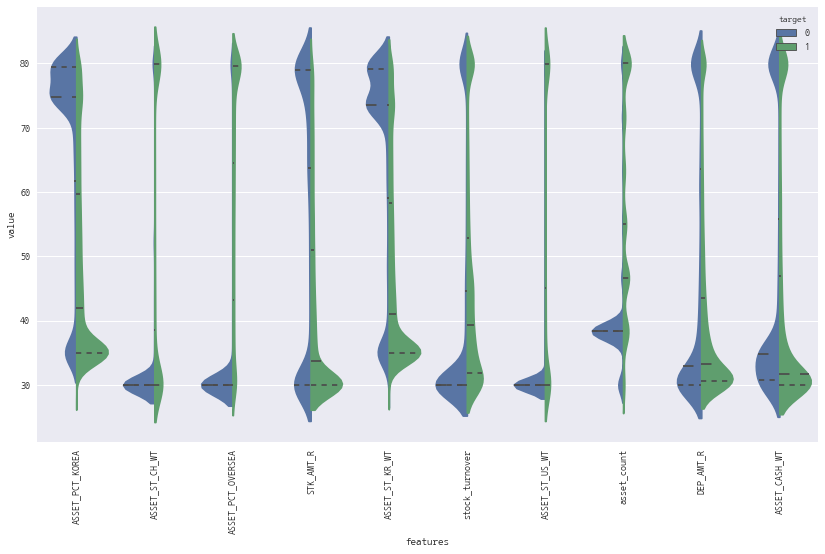

In [125]:
data_dia = y
data = X[top20_num]

data_n_2 = data.apply(lambda x: quarter_normalize(x))

# data_n_2 = ( data - data.mean()) / (data.std())  # standardization
data = pd.concat([y, data_n_2.iloc[:, :10]], axis=1)  # 상위 10개 먼저
data = pd.melt(data, id_vars="target",
                     var_name="features",
                     value_name="value")
plt.figure(figsize=(14,8))
sns.violinplot(x='features', y='value', hue='target', data=data, split=True, inner='quart')
plt.xticks(rotation=90)      

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

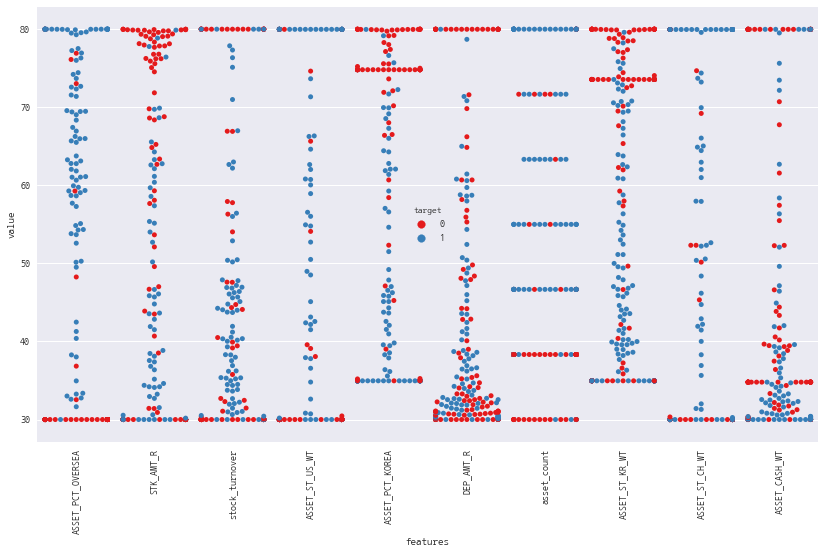

In [126]:
data_s = data.sample(2000)
plt.figure(figsize=(14,8))
sns.swarmplot(x='features', y='value', hue='target', data=data_s, palette="Set1")
plt.xticks(rotation=90)      

☞ 해외주식 거래여부에 유의한 영향을 미치는 요소는?  
- 자산배분 다양성 : 해외자산(특히 미국, 중국) 보유, 자산군 갯수 많아야 함
- 자산 중 주식 주식비중이 낮아야 하며, 주식거래는 꾸준하게 있어야 함(회전율)
- 투자여력 : 현금자산(예수금) 보유

** Feature Importance 최상위 11~20개 시각화**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

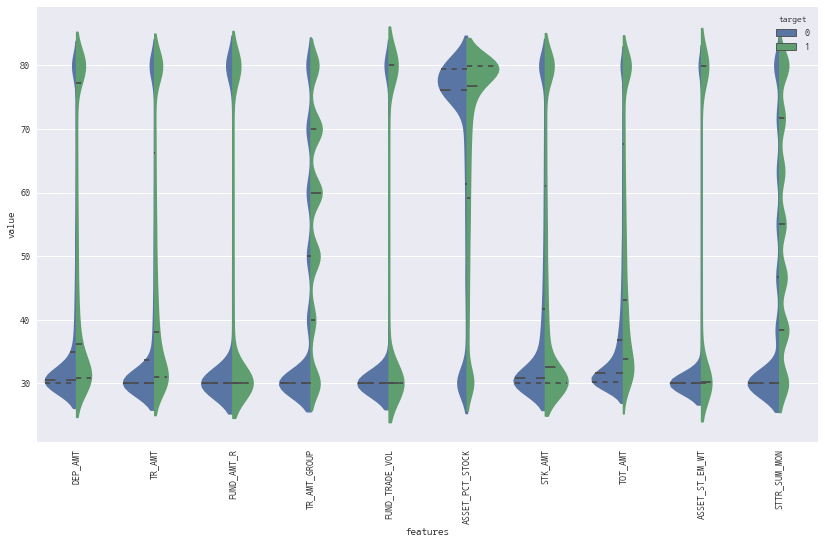

In [127]:
data_dia = y
data = X[top20_num]

data_n_2 = data.apply(lambda x: quarter_normalize(x))

# data_n_2 = ( data - data.mean()) / (data.std())  # standardization
data = pd.concat([y, data_n_2.iloc[:, 10:]], axis=1)  # 그 다음 10개
data = pd.melt(data, id_vars="target",
                     var_name="features",
                     value_name="value")
plt.figure(figsize=(14,8))
sns.violinplot(x='features', y='value', hue='target', data=data, split=True, inner='quart')
plt.xticks(rotation=90)      

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

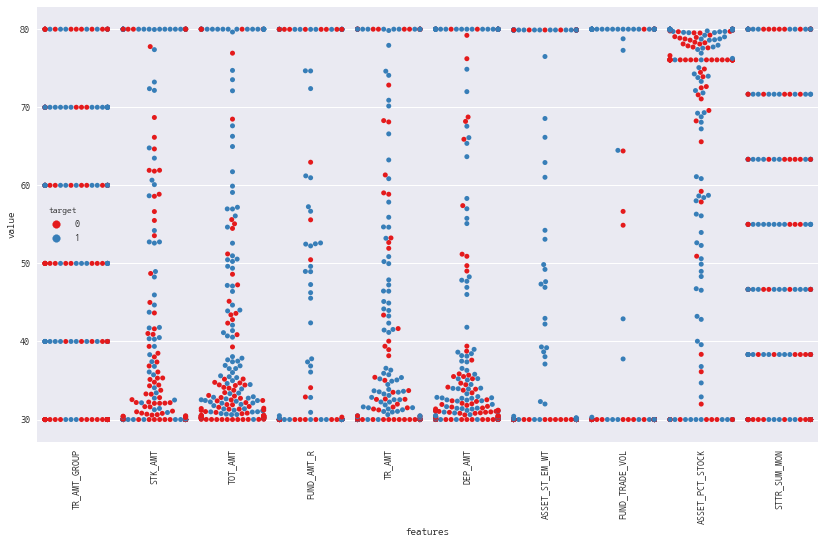

In [128]:
data_s = data.sample(2000)
plt.figure(figsize=(14,8))
sns.swarmplot(x='features', y='value', hue='target', data=data_s, palette="Set1")
plt.xticks(rotation=90)      

☞ 해외주식 거래여부에 유의한 영향을 미치는 요소는?  
- 상대적으로 자산규모가 큰 VIP 고객
- 펀드자산 보유, 펀드 거래

주요 피처 깊게 보기 : 히스토그램, t-Test

In [113]:
def num_summary(x, y, desc, log_trans=1):  # x분석변수, y타겟(0,1)    
    print(" === 해외주식 요약 통계 : {0} === ".format(desc))
    
    # 로그변환 히스토그램 : 최소값 계산해서 1부터 시작하도록 조정
    x_min = np.abs(np.min(x)) + 1
    x_log = x.apply(lambda n: np.log(n+x_min))
    
    if log_trans == 1:
        xy = pd.concat([x_log, y], axis=1)
    else:
        xy = pd.concat([x, y], axis=1)
        
    plt.figure(figsize=(12,6))
    xy.columns = ['X', 'Y']
    xy[xy['Y']==0]['X'].hist(bins=70, alpha=0.2, color='b', label='0')
    xy[xy['Y']==1]['X'].hist(bins=70, alpha=0.2, color='g', label='1')    
    plt.legend(title='target')
    plt.show();      
    
    ###### t-통계량의 절대값이 클수록 귀무가설을 강력하게 기각함 #####
    # t-test : 
    s, _ = stats.ttest_ind(xy[xy['Y']==0]['X'],
                           xy[xy['Y']==1]['X'],
                           equal_var = False)
    print(" T-test statistics : ", s)
    
    # 요약통계
    ta = xy['X'].describe()
    t0 = xy[xy['Y']==0]['X'].describe()
    t1 = xy[xy['Y']==1]['X'].describe()
    tot = pd.concat([ta, t0, t1], axis=1)     # .applymap('{:,.0f}'.format)
    tot.columns = ['전체', '미거래', '거래']
    return tot

 === 해외주식 요약 통계 : 해외자산비중 === 


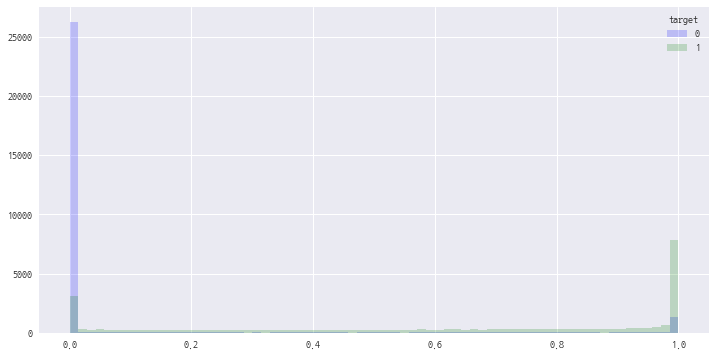

 T-test statistics :  -202.947792145


,전체,미거래,거래
count,"60,000.0000","30,000.0000","30,000.0000"
mean,0.3448,0.0835,0.6062
std,0.4097,0.2523,0.3680
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.2649
50%,0.0398,0.0000,0.6919
75%,0.7799,0.0000,0.9910
max,1.0000,1.0000,1.0000


In [114]:
num_summary(df['ASSET_PCT_OVERSEA'], df['target'], '해외자산비중', log_trans=0).applymap('{:,.4f}'.format) 

 === 해외주식 요약 통계 : 자산군개수(포트폴리오 다양성) === 


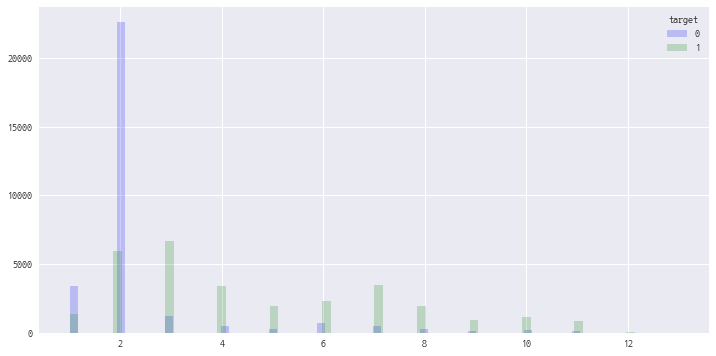

 T-test statistics :  -130.470137239


,전체,미거래,거래
count,"60,000.0000","30,000.0000","30,000.0000"
mean,3.5171,2.3559,4.6784
std,2.4701,1.5390,2.6716
min,1.0000,1.0000,1.0000
25%,2.0000,2.0000,3.0000
50%,2.0000,2.0000,4.0000
75%,4.0000,2.0000,7.0000
max,13.0000,12.0000,13.0000


In [115]:
num_summary(df['asset_count'], df['target'], '자산군개수(포트폴리오 다양성)', log_trans=0).applymap('{:,.4f}'.format) 

 === 해외주식 요약 통계 : 주식거래금액(로그변환) === 


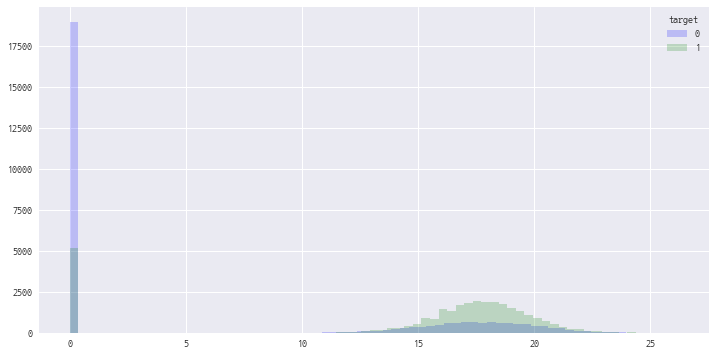

 T-test statistics :  -129.092943573


,전체,미거래,거래
count,"60,000.0000","30,000.0000","30,000.0000"
mean,10.5980,6.4769,14.7191
std,8.8391,8.6073,6.9432
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,15.2338
50%,15.6813,0.0000,17.2848
75%,18.1838,16.4941,18.7795
max,26.2074,26.2074,25.8567


In [116]:
num_summary(df['TR_AMT'], df['target'], '주식거래금액(로그변환)', log_trans=1).applymap('{:,.4f}'.format) 

 === 해외주식 요약 통계 : 총자산(로그변환) === 


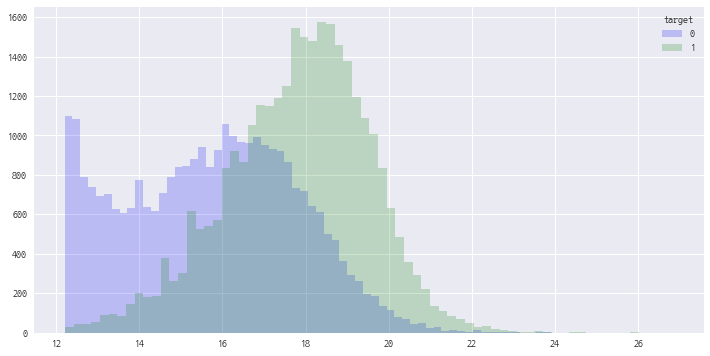

 T-test statistics :  -132.962804266


,전체,미거래,거래
count,"60,000.0000","30,000.0000","30,000.0000"
mean,16.7702,15.7368,17.8037
std,2.1663,2.0686,1.7235
min,12.2061,12.2061,12.2198
25%,15.3000,14.0191,16.7124
50%,16.9752,15.8287,17.9458
75%,18.3884,17.2871,18.9932
max,26.8460,25.4225,26.8460


In [117]:
num_summary(df['TOT_AMT'], df['target'], '총자산(로그변환)', log_trans=1).applymap('{:,.4f}'.format) 

 === 해외주식 요약 통계 : 예수금자산(로그변환) === 


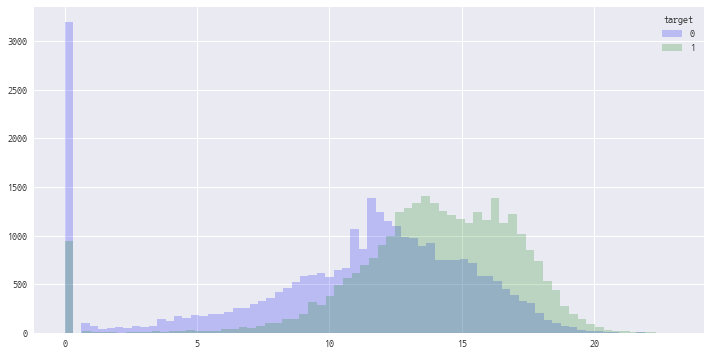

 T-test statistics :  -89.5148800289


,전체,미거래,거래
count,"60,000.0000","30,000.0000","30,000.0000"
mean,12.1800,10.5847,13.7752
std,4.6477,4.9512,3.6876
min,0.0000,0.0000,0.0000
25%,10.5570,8.4722,12.2833
50%,13.0446,11.7061,14.1939
75%,15.3771,13.9803,16.2305
max,22.9875,22.2222,22.9875


In [118]:
num_summary(df['DEP_AMT'], df['target'], '예수금자산(로그변환)', log_trans=1).applymap('{:,.4f}'.format) 

---
** 텍스트 피처 : 집계표와 카이스퀘어 통계량으로 분석하기**

In [25]:
def chisq_test(x, y, desc):
    print(" === 해외주식 집계표 : {0} === ".format(desc))
    
    # 집계표 만든다.
    cont = pd.crosstab(x, y)
    cont_table = pd.concat([cont, cont/30000*100], axis=1)   # 데이터가 3만개씩 똑같으므로, 3만개로 나눠주면 비중이 된다
    cont_table.columns = ['미거래', '거래', '미거래%', '거래%']
    
    # 카이스퀘어 검정 통계량
    chi_test, pvalue, _, _ = chi2_contingency(cont)
    print('Chi-square test stats: {0:.4f}, P-values: {1:.8f}'.format(chi_test, pvalue))
    
    return cont_table    

In [67]:
chisq_test(df['CUST_GRAD_CD'], df['target'], desc="고객등급").\
    style.bar(subset=['미거래%', '거래%'], color='#5fba7d', width=70)

 === 해외주식 집계표 : 고객등급 === 
Chi-square test stats: 10746.9524, P-values: 0.00000000


In [66]:
chisq_test(df['manager'], df['target'], desc="관리자여부(0이 관리자 있음)").\
    style.bar(subset=['미거래%', '거래%'], color='#5fba7d', width=70)

 === 해외주식 집계표 : 관리자여부(0이 관리자 있음) === 
Chi-square test stats: 9351.6069, P-values: 0.00000000


In [65]:
chisq_test(df['goods_2'], df['target'], desc="주상품").\
    style.bar(subset=['미거래%', '거래%'], color='#5fba7d', width=70)

 === 해외주식 집계표 : 주상품 === 
Chi-square test stats: 3276.4758, P-values: 0.00000000


In [69]:
chisq_test(df['max_channel'], df['target'], desc="주사용 온라인매체").\
    style.bar(subset=['미거래%', '거래%'], color='#5fba7d', axis=0, width=50)

 === 해외주식 집계표 : 주사용 온라인매체 === 
Chi-square test stats: 3213.7344, P-values: 0.00000000


☞ 해외주식 거래여부에 유의한 영향을 미치는 요소는?  
- VIP고객 : 해외주식 거래고객은 A등급(최하등급)을 제외한 나머지 고객의 비중이 높음
- 관리자가 배정된 고객
- 주로 거래하는 상품은 주식이 많음. 또한, 랩/신탁/채권 등 VIP에게 적합한 상품도 주거래 성향 높음
- 가장 선호하는 온라인매체는 HTS

---
## 3. 모델링
**목적**
  1. 해외주식 거래 확률 예측
  2. 머신러닝 모델 간의 성능 비교
  
**모델** 
  1. 로지스틱 회귀
  2. 랜덤포레스트
  3. DNN(텐서플로+Keras) 

---
** 데이터를 표준화 한다. **
1. 표준정규화 : standardization 
2. 최대최소 범위 조정 : min-max

In [129]:
# Starndization : LR, RF
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

# Min-Max : DNN
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

---
** 모델링 결과물 요약 함수 : 혼동행렬 **

In [149]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


def model_summary(y_, pre_):
    ac_score = metrics.accuracy_score(y_, pre_)
    cl_report = metrics.classification_report(y_, pre_)

    print("정답률 =", ac_score)
    print('-'*50)
    print("리포트 = \n", cl_report)   # precision => 실제 1 / 예측 1,  recall => 예측 1 / 실제 1
    print('-'*50)
    
    # 혼동행렬
    print("혼동행렬 = \n")
    confmat = confusion_matrix(y_, pre_)
    pred_df = pd.DataFrame({'real':y_, 'pred':pre_})
    print(pd.crosstab(pred_df['real'], pred_df['pred'], margins=True))
    
    # 혼동행렬 차트
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat,
               cmap=plt.cm.Blues,
               alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i,
                    s=confmat[i, j],
                    fontsize=14,
                    va='center', ha='center')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Real', fontsize=14)
    plt.show()

### 1. 로지스틱 회귀

====== 로지스틱 회귀 결과 : 원본 데이터 =====
정답률 = 0.921611111111
--------------------------------------------------
리포트 = 
              precision    recall  f1-score   support

          0       0.91      0.94      0.92      8944
          1       0.94      0.90      0.92      9056

avg / total       0.92      0.92      0.92     18000

--------------------------------------------------
혼동행렬 = 

pred     0     1    All
real                   
0     8397   547   8944
1      864  8192   9056
All   9261  8739  18000


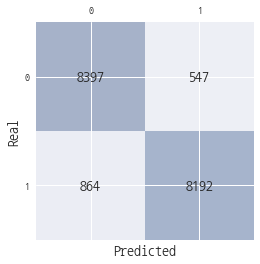

In [195]:
# 로지스틱 회귀 : 원본 데이터로
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10)
lr.fit(X_train_std, y_train)

# 값으로 예측한다
pred_lr = lr.predict(X_test_std)
# 확률로 예측한다
pred_proba_lr = lr.predict_proba(X_test_std)

lr_pr_score = precision_score(y_true=y_test, y_pred=pred_lr)  # 정밀도(precision) : 양성 예측시 중 양성 정확도 비중
lr_re_score = recall_score(y_true=y_test, y_pred=pred_lr)     # 재현율(recall) : 실제 양성 전체에서 양성 예측 비중
lr_f1_score = f1_score(y_true=y_test, y_pred=pred_lr)         # f1 score (정확도와 정밀도의 조합)

print("====== 로지스틱 회귀 결과 : 원본 데이터 =====")
model_summary(y_test, pred_lr)

### 2. 랜덤 포레스트

====== 랜덤포레스트 =====
정답률 = 0.915722222222
--------------------------------------------------
리포트 = 
              precision    recall  f1-score   support

          0       0.91      0.92      0.92      8944
          1       0.92      0.91      0.92      9056

avg / total       0.92      0.92      0.92     18000

--------------------------------------------------
혼동행렬 = 

pred     0     1    All
real                   
0     8273   671   8944
1      846  8210   9056
All   9119  8881  18000


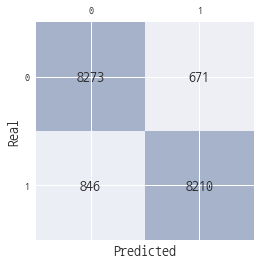

In [196]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100,   # 트리 반복 횟수
                                max_depth=3,         # 트리 깊이
                                random_state=42)
forest.fit(X_train_std, y_train)
pred_rf = forest.predict(X_test_std)
pred_proba_rf = forest.predict_proba(X_test_std)

rf_pr_score = precision_score(y_true=y_test, y_pred=pred_rf)  # 정밀도(precision) : 양성 예측시 중 양성 정확도 비중
rf_re_score = recall_score(y_true=y_test, y_pred=pred_rf)     # 재현율(recall) : 실제 양성 전체에서 양성 예측 비중
rf_f1_score = f1_score(y_true=y_test, y_pred=pred_rf)         # f1 score (정확도와 정밀도의 조합)

print("====== 랜덤포레스트 =====")
model_summary(y_test, pred_rf)

### 3. 텐서플로

In [162]:
from keras.models import Sequential
from keras.layers.core import Dense
import tensorflow as tf

In [286]:
seed = 42
np.random.seed(42)
tf.set_random_seed(42)

model = Sequential()
model.add(Dense(24, input_dim=X_train_norm.shape[1], activation='relu'))  # input_dim : 피처 수 입력
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# model.fit(X_train_norm, y_train, epochs=100, batch_size=5)
history = model.fit(X_train_norm, y_train, 
                    validation_split=0.3, epochs=100, batch_size=5)
                    
print("\n Test Accuracy: {:.4f}".format(model.evaluate(X_test_norm, y_test)[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 24)                2280      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                250       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 2,541
Trainable params: 2,541
Non-trainable params: 0
_________________________________________________________________
Train on 29399 samples, validate on 12601 samples
Epoch 1/100
29399/29399 [==============================] - 10s - loss: 0.2198 - acc: 0.9129 - val_loss: 0.1770 - val_acc: 0.9322
Epoch 2/100
29399/29399 [==============================] - 10s - loss: 0.1677 - acc: 0.9354 - val_loss: 0.1653 - val_acc: 0.9378
Epoch 3/100
29399/29399 [==============================] - 10s - loss: 0.1535 - acc: 0.9421 - va

29399/29399 [==============================] - 10s - loss: 0.0979 - acc: 0.9638 - val_loss: 0.1457 - val_acc: 0.9500
Epoch 59/100
29399/29399 [==============================] - 11s - loss: 0.0971 - acc: 0.9644 - val_loss: 0.1488 - val_acc: 0.9456
Epoch 60/100
29399/29399 [==============================] - 11s - loss: 0.0974 - acc: 0.9645 - val_loss: 0.1489 - val_acc: 0.9487
Epoch 61/100
29399/29399 [==============================] - 11s - loss: 0.0974 - acc: 0.9654 - val_loss: 0.1463 - val_acc: 0.9484
Epoch 62/100
29399/29399 [==============================] - 11s - loss: 0.0965 - acc: 0.9644 - val_loss: 0.1537 - val_acc: 0.9468
Epoch 63/100
29399/29399 [==============================] - 11s - loss: 0.0961 - acc: 0.9651 - val_loss: 0.1613 - val_acc: 0.9456
Epoch 64/100
29399/29399 [==============================] - 11s - loss: 0.0957 - acc: 0.9644 - val_loss: 0.1550 - val_acc: 0.9477
Epoch 65/100
29399/29399 [==============================] - 10s - loss: 0.0957 - acc: 0.9652 - val_loss

In [242]:
history.params

{'batch_size': 5,
 'do_validation': True,
 'epochs': 5,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'samples': 29399,
 'verbose': 1}

학습 커브 : Epoch 20번 이상에서 Validation의 정확도(accuracy) 수렴

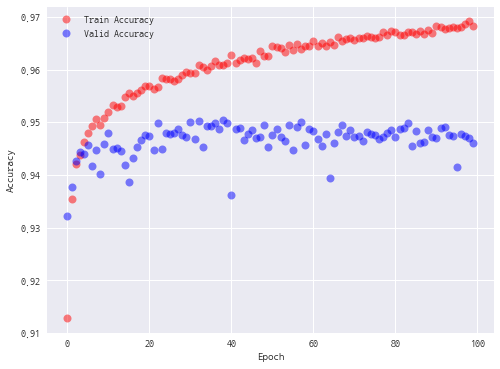

In [291]:
train_acc = history.history['acc']
valid_acc = history.history['val_acc']

x_len = np.arange(len(train_acc))

plt.figure(figsize=(8,6))
plt.plot(x_len, train_acc, 'o', c='r', markersize=8, alpha=0.5, label='Train Accuracy')
plt.plot(x_len, valid_acc, 'o', c='b', markersize=8, alpha=0.5, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

16448/18000 [==========================>...] - ETA: 0s

====== DNN(tensorflow) =====
정답률 = 0.952277777778
--------------------------------------------------
리포트 = 
              precision    recall  f1-score   support

          0       0.94      0.96      0.95      8944
          1       0.96      0.94      0.95      9056

avg / total       0.95      0.95      0.95     18000

--------------------------------------------------
혼동행렬 = 

pred     0     1    All
real                   
0     8614   330   8944
1      529  8527   9056
All   9143  8857  18000


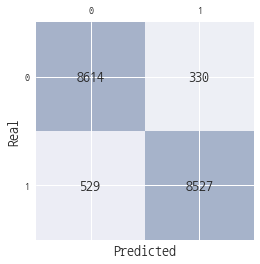

In [201]:
pred_tf = model.predict_classes(X_test_norm).flatten()
pred_proba_tf = model.predict_proba(X_test_norm).flatten()    # N X 1 행렬(1에 대한 확률값만 들어있음, sklearn은 N X 2

tf_pr_score = precision_score(y_true=y_test, y_pred=pred_tf)  # 정밀도(precision) : 양성 예측시 중 양성 정확도 비중
tf_re_score = recall_score(y_true=y_test, y_pred=pred_tf)     # 재현율(recall) : 실제 양성 전체에서 양성 예측 비중
tf_f1_score = f1_score(y_true=y_test, y_pred=pred_tf)         # f1 score (정확도와 정밀도의 조합)

print("\n\n====== DNN(tensorflow) =====")
model_summary(y_test, pred_tf)

**3개 모델의 성능을 합쳐서 비교해보자**

In [202]:
pr_score = [lr_pr_score, rf_pr_score, tf_pr_score]
re_score = [lr_re_score, rf_re_score, tf_re_score]
f1_score = [lr_f1_score, rf_f1_score, tf_f1_score]
model_nm = ["Logistic", "RandomForest", "DNN"]

df_model_summary = pd.DataFrame({'pr_score': pr_score, 're_score': re_score, 'f1_score': f1_score},
                                index=model_nm)
df_model_summary

,f1_score,pr_score,re_score
Logistic,0.920708,0.937407,0.904594
RandomForest,0.915426,0.924445,0.906581
DNN,0.952046,0.962741,0.941586


---
① 정밀도(Precision)  
- 1로 예측한 값 중 실제 1인 값(=TP/TP+FP)

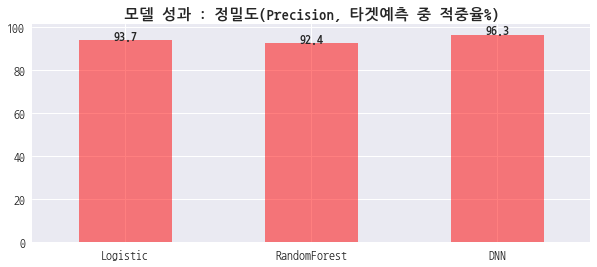

In [203]:
### Precision ###
ser = df_model_summary['pr_score'].apply(lambda x: x*100)  # %로 변환
ax = ser.plot(kind='bar', color='red', alpha=0.5, figsize=(10,4), rot=0, fontsize=12)
ax.set_title("모델 성과 : 정밀도(Precision, 타겟예측 중 적중율%)", fontdict={'fontsize':15, 'fontweight':'bold'})

# 값 차트 표기
for i, v in enumerate(ser):
    ax.text(i, v+0.50,               # 표기할 x, y
            np.round(v,1),            # 값(소수점 첫째 자리)
            fontsize=12, fontweight='bold', horizontalalignment='center')

---
② 재현율(Recall, Sensitive)  
- 실제 1인 값 중에서 1로 예측한 값(=TP/TP+FN)

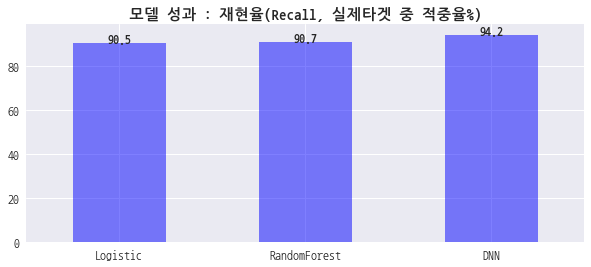

In [204]:
### Recall ###
ser = df_model_summary['re_score'].apply(lambda x: x*100)  # %로 변환
ax = ser.plot(kind='bar', color='blue', alpha=0.5, figsize=(10,4), rot=0, fontsize=12)
ax.set_title("모델 성과 : 재현율(Recall, 실제타겟 중 적중율%)", fontdict={'fontsize':15, 'fontweight':'bold'})

# 값 차트 표기
for i, v in enumerate(ser):
    ax.text(i, v+0.50,               # 표기할 x, y
            np.round(v,1),            # 값(소수점 첫째 자리)
            fontsize=12, fontweight='bold', horizontalalignment='center')

---
③ f-1 score
- 정밀도(Precision)와 재현율(Recall)의 조화평균

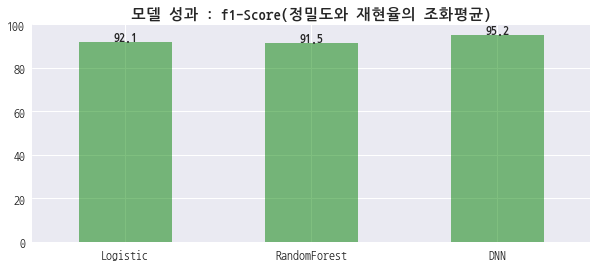

In [205]:
### f1-score ###
ser = df_model_summary['f1_score'].apply(lambda x: x*100)  # %로 변환
ax = ser.plot(kind='bar', color='green', alpha=0.5, figsize=(10,4), rot=0, fontsize=12)
ax.set_title("모델 성과 : f1-Score(정밀도와 재현율의 조화평균)", fontdict={'fontsize':15, 'fontweight':'bold'})

# 값 차트 표기
for i, v in enumerate(ser):
    ax.text(i, v+0.50,               # 표기할 x, y
            np.round(v,1),            # 값(소수점 첫째 자리)
            fontsize=12, fontweight='bold', horizontalalignment='center')

---
④ ROC커브
- 민감도(True Positive Rate)/특이도(True Negative Rate)의 도표
- 완벽한 분류기는 민감도는 1, 특이도가 0이 됨
- ROC커브의 면적(AUC: Area Under Curve)이 1에 가까울수록 모델 성능 우수

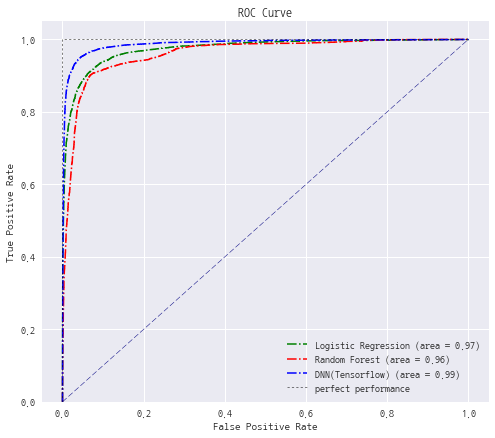

In [209]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

fig = plt.figure(figsize=(8,7))

# 모델별 차트 그리기
def roc_plot(y, pred, color, model_name):
    fpr, tpr, threshgolds = roc_curve(y, pred, pos_label=1)   
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color,
             lw=1.5, linestyle='-.', label=model_name + " (area = %0.2f)" % roc_auc)     # lw : 선 두께

# 실제값과 예측확률값 매칭(텐서프로는 NX1 행렬임에 유의)
roc_plot(y=y_test, pred=pred_proba_lr[:, 1], color="green", model_name="Logistic Regression")
roc_plot(y=y_test, pred=pred_proba_rf[:, 1], color="red",   model_name="Random Forest")    
roc_plot(y=y_test, pred=pred_proba_tf,       color="blue",  model_name="DNN(Tensorflow)") 
    
# 보조선
plt.plot([0,0,1], [0,1,1], color='black', lw=0.5, linestyle=':', label='perfect performance')
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.00, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

---
⑤ 누적응답곡선(Cumulative Response Curve)
- x축은 타겟팅 비율, y축은 정확하게 분류된 타겟 비율
- 누적응답곡선은 종종 향상도(Lift) 곡선으로도 불림. 이는 대각선을 기준으로 얼마나 향상되었는지를 평가할 수 있기 떄문

In [ ]:
from scikitplot as skplot  # 사이킷런 추가 라이브러리

# DNN(텐서플로)만 시각화
skplot.metrics.plot_cumulative_gain(y_test, pred_proba_tf)

<img src="cum_gain_plot.png">

---
## 시사점

- 데이터 기초 분석 필수 선행 : 분포 확인, 표준화, 그리고 해석(해외주식 거래고객은 누구인가?)  
- 해외주식 거래여부에 영향을 많이 미치는 피처 : 자산배분 다양성, 자산규모, 거래활동 등  
- 모델별 성능 평가 : DNN(텐서플로) >> 로지스틱 회귀모형 > 랜덤포레스트
- 비즈니스 활용 : 예측 모델 결과를 전체 거래고객 반영 후 해외주식 거래 관심 상위 고객 순으로 아웃바운드 콜 진행

---
## 에필로그 : 풀지못한 숙제

**① 텐서플로의 복잡한 옵션들!!!**  

=> relu? sigmoid? epochs? batch_size?

** ② 타겟에 미치는 영향력이 큰 피처를 찾는 효과적인 방법은?**

** ③ PCA : 어디에 쓰는 물건인고?**

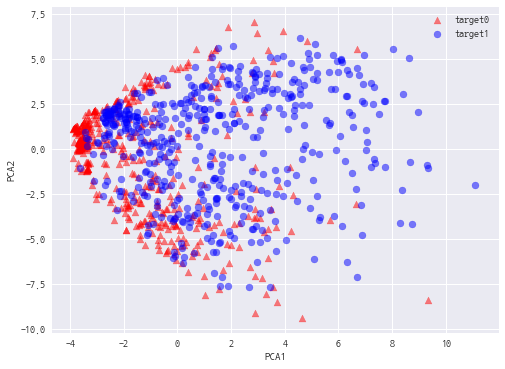

In [283]:
# PCA -> 피처 2개로 ...
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_train_std)

# 타겟 데이터와 합친다. 
pca_df = pd.concat([pd.DataFrame(x_pca), 
                    y_train.reset_index(drop=True)],    # 인덱스 정렬해줘야 함
                   axis=1)
pca_df.columns = ['PCA1','PCA2', 'target']

# 샘플링 후 차트 그리기
n = 1000
pca_df = pca_df.sample(n)

plt.figure(figsize=(8,6))

plt.scatter(pca_df[pca_df['target']==0]['PCA1'],
            pca_df[pca_df['target']==0]['PCA2'],
            marker='^', color='r', alpha=0.5, label='target0')
plt.scatter(pca_df[pca_df['target']==1]['PCA1'],
            pca_df[pca_df['target']==1]['PCA2'],
            marker='o', color='b', alpha=0.5, label='target1')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()